In [1]:
!pip install --upgrade -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 5.6 MB/s eta 0:00:00


In [2]:
import os
import re
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


In [3]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0
IMAGE_SIZE = 416

In [4]:
# Class mapping
class_ids = ['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [6]:
def get_labels(labels_dir: str, img_size: int = 416) -> (list, list):
    file_paths = []
    classes = []
    boxes = []
    # Get labels: class ID and x, y, width, height (bounding boxes)
    for root, dirs, files in os.walk(labels_dir):
        for file in files:
            # Get path for each label .txt file
            label_path = os.path.join(labels_dir, os.path.splitext(file)[0] + ".txt")
            file_paths.append(label_path)

        # Sort paths by picture name
        pattern = r"(\d+)_jpg\.rf"
        file_paths.sort(key=lambda x: int(re.findall(pattern, x)[0]))

        for file in file_paths:
            # Open label .txt file
            with open (file, "r") as label_file:
                label_lines = label_file.readlines()

                img_classes = []
                img_boxes = []

                # Parse label lines
                for line in label_lines:
                    parts = line.split()
                    single_class = int(parts[0])  # First value is the class label
                    img_classes.append(single_class)

                    single_box = [float(x) * img_size for x in parts[1:]]  # Rest are the boxes (x,y and height,width)
                    img_boxes.append(single_box)

                classes.append(img_classes)
                boxes.append(img_boxes)
    return classes, boxes

In [7]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Put Colab in the context of the project
os.chdir('/content/drive/MyDrive/Colab Notebooks/blackjack')

In [8]:
# Unzip dataset with images
# IMPORTANT! Clean zip from Mac dot files!
!unzip -u "/content/drive/My Drive/Colab Notebooks/blackjack/cards_archive/cards_clean.zip" -d "/content/drive/My Drive/Colab Notebooks/blackjack/cards_archive"

Archive:  /content/drive/My Drive/Colab Notebooks/blackjack/cards_archive/cards_clean.zip


In [ ]:
#TODO !only to run locally!
#train_dir_imgs  = '/Users/sergi/Downloads/cards_archive/train/images'
#train_dir_labels = '/Users/sergi/Downloads/cards_archive/train/labels'

#valid_dir_imgs = '/Users/sergi/Downloads/cards_archive/valid/images'
#valid_dir_labels = '/Users/sergi/Downloads/cards_archive/valid/labels'

#test_dir_imgs = '/Users/sergi/Downloads/cards_archive/test/images'
#test_dir_labels = '/Users/sergi/Downloads/cards_archive/test/labels'

In [9]:
train_dir_imgs  = '/content/drive/My Drive/Colab Notebooks/blackjack/cards_archive/train/images'
train_dir_labels = '/content/drive/My Drive/Colab Notebooks/blackjack/cards_archive/train/labels'

valid_dir_imgs = '/content/drive/My Drive/Colab Notebooks/blackjack/cards_archive/valid/images'
valid_dir_labels = '/content/drive/My Drive/Colab Notebooks/blackjack/cards_archive/valid/labels'

test_dir_imgs = '/content/drive/My Drive/Colab Notebooks/blackjack/cards_archive/test/images'
test_dir_labels = '/content/drive/My Drive/Colab Notebooks/blackjack/cards_archive/test/labels'

In [10]:
train_classes, train_boxes = get_labels(train_dir_labels)
valid_classes, valid_boxes = get_labels(valid_dir_labels)
test_classes, test_boxes = get_labels(test_dir_labels)

In [11]:
def get_imgs(imgs_dir: str) -> (list):
    paths = []
    for root, dirs, files in os.walk(imgs_dir):
        for file in files:
            img_path = os.path.join(imgs_dir, os.path.splitext(file)[0] + ".jpg")
            paths.append(img_path)
    paths.sort()
    return paths

In [12]:
train_img_paths = get_imgs(train_dir_imgs)
valid_img_paths = get_imgs(valid_dir_imgs)
test_img_paths = get_imgs(test_dir_imgs)

In [14]:
len(train_img_paths)

4000

In [15]:
len(valid_classes)

4000

In [16]:
# Check correct size
assert len(train_classes) == len(train_boxes) == len(train_img_paths)
assert len(valid_classes) == len(valid_boxes) == len(valid_img_paths)
assert len(test_classes) == len(test_boxes) == len(test_img_paths)

In [17]:
# Creating data, after converting lists to ragged tensors
# Train dataset:
train_classes_tf = tf.ragged.constant(train_classes)
train_boxes_tf = tf.ragged.constant(train_boxes)
train_paths_tf = tf.ragged.constant(train_img_paths)

train_data = tf.data.Dataset.from_tensor_slices((train_paths_tf, train_classes_tf, train_boxes_tf))

# Validation dataset:
valid_classes_tf = tf.ragged.constant(valid_classes)
valid_boxes_tf = tf.ragged.constant(valid_boxes)
valid_paths_tf = tf.ragged.constant(valid_img_paths)

valid_data = tf.data.Dataset.from_tensor_slices((valid_paths_tf, valid_classes_tf, valid_boxes_tf))

# Test dataset:
test_classes_tf = tf.ragged.constant(test_classes)
test_boxes_tf = tf.ragged.constant(test_boxes)
test_paths_tf = tf.ragged.constant(test_img_paths)

test_data = tf.data.Dataset.from_tensor_slices((test_paths_tf, test_classes_tf, test_boxes_tf))

In [18]:
# Loading data functions
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [20]:
# Data augmentater for the training dataset
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xywh"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(416, 416), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
        ),
    ]
)

In [21]:
# Creating training dataset
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
# Data resizer for the validation dataset
resizing = keras_cv.layers.JitteredResize(
    target_size=(416, 416),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xywh",
)

In [20]:
# Creating validation dataset
val_ds = valid_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

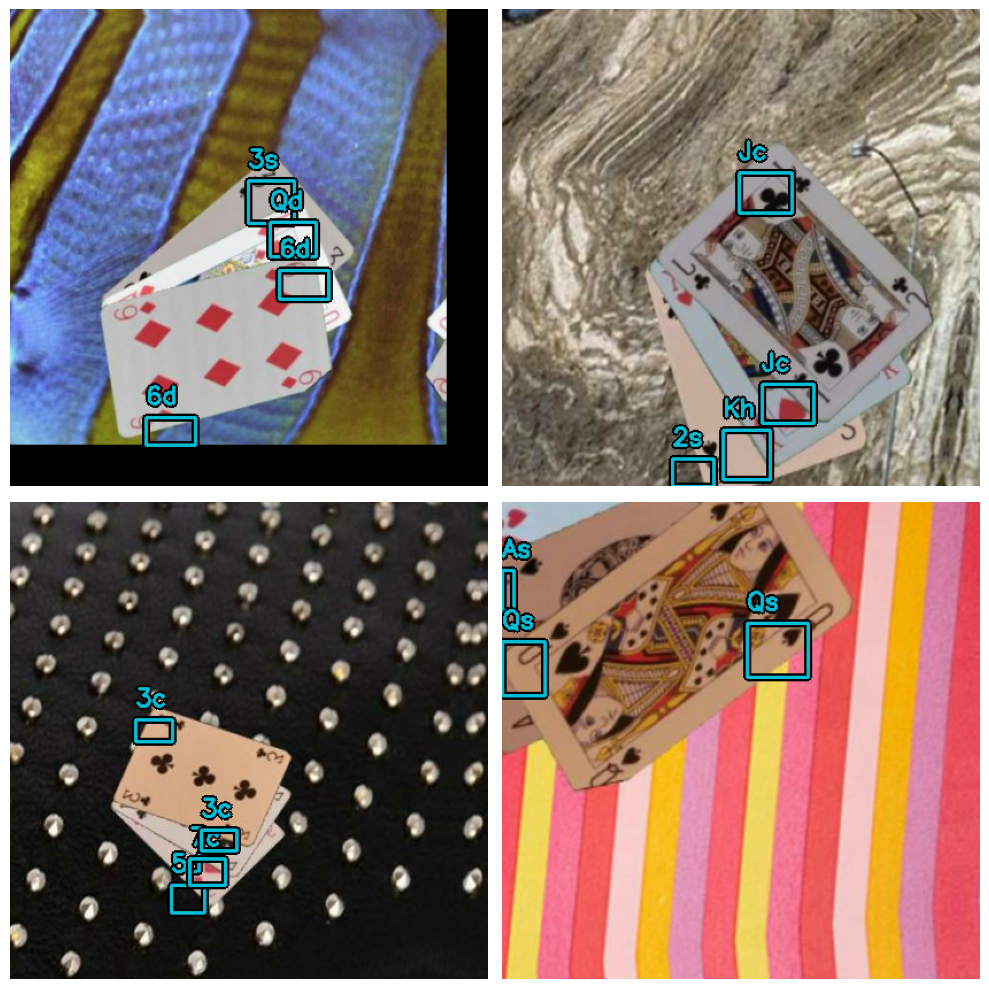

In [25]:
# Visualize training dataset
visualize_dataset(train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2)

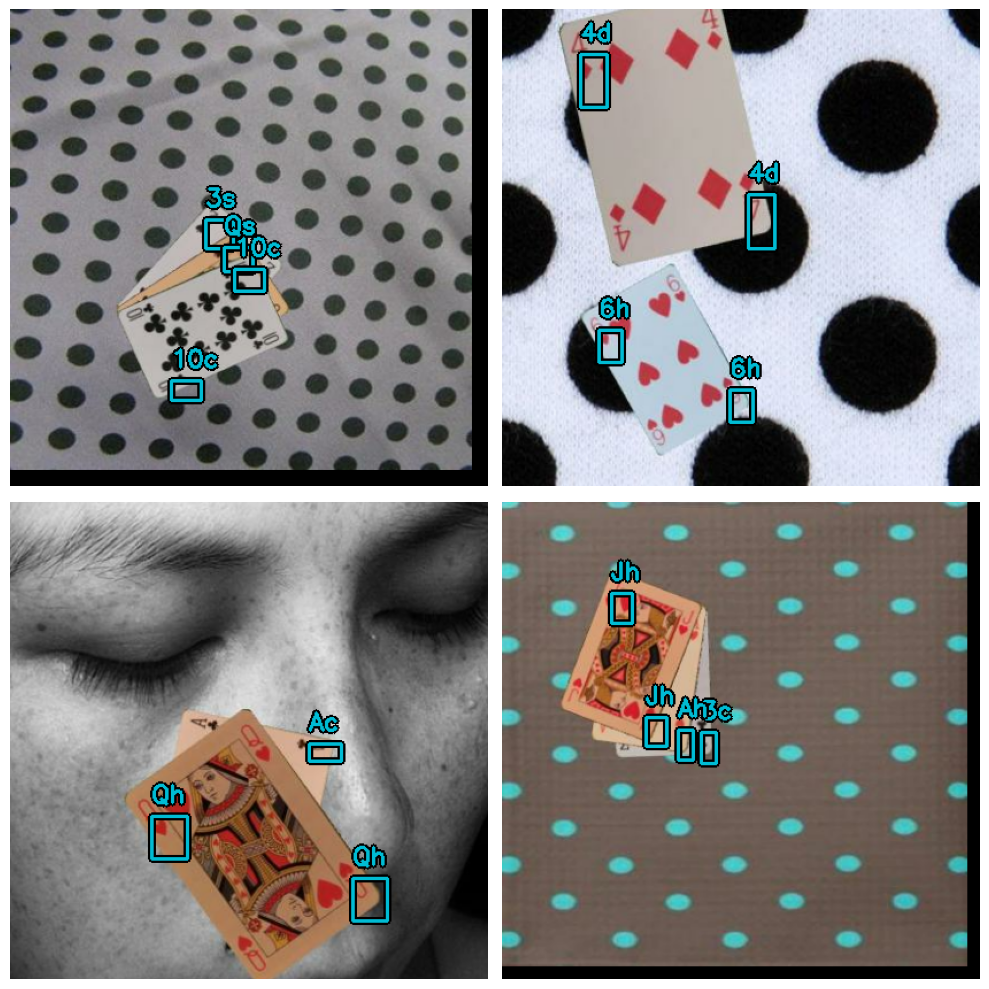

In [22]:
# Visualize validation dataset
visualize_dataset(val_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2)

# MODEL CREATION (YOLOv8)

In [26]:
# YOLOv8 backbone
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone_coco")  # yolov8 backbone with coco weights

5347160/5347160 [==============================] - 0s 0us/step


In [27]:
# Build the model
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
    backbone=backbone,
    fpn_depth=1, # Feature Pyramid Network
)

In [28]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, global_clipnorm=GLOBAL_CLIPNORM,)

yolo.compile(optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou")

In [29]:
# Model evaluation with COCO Metric Callback
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xywh",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images = batch["images"]
            bounding_boxes = batch["bounding_boxes"]

            # Extract "boxes" and "classes" from bounding_boxes
            classes = bounding_boxes["classes"]
            boxes = bounding_boxes["boxes"]

            y_pred = self.model.predict(images, verbose=0)

            # Convert classes and bounding_boxes to a dictionary
            y_true = {"classes": classes, "boxes": boxes}

            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [52]:
# Model training
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "/content/drive/My Drive/Colab Notebooks/blackjack/model.h5")],
    verbose=1
)

yolo.save("/content/drive/My Drive/Colab Notebooks/blackjack/all_model.h5")

Epoch 1/3
3500/3500 [==============================] - 1014s 275ms/step - loss: 10.0522 - box_loss: 2.2817 - class_loss: 7.7706 - val_loss: 1.7289 - val_box_loss: 1.6519 - val_class_loss: 0.0769
Epoch 2/3
3500/3500 [==============================] - 975s 279ms/step - loss: 1.6188 - box_loss: 1.5476 - class_loss: 0.0712 - val_loss: 1.5630 - val_box_loss: 1.4944 - val_class_loss: 0.0686
Epoch 3/3
3500/3500 [==============================] - 1006s 287ms/step - loss: 1.5199 - box_loss: 1.4531 - class_loss: 0.0667 - val_loss: 1.5380 - val_box_loss: 1.4739 - val_class_loss: 0.0641


In [ ]:
# Save the fitted model
#yolo.save("/Users/sergi/Downloads/model_v00")
yolo.save("/content/drive/My Drive/Colab Notebooks/blackjack/all_model.h5")

In [34]:
# Loading the saved model...

# Create a new instance of YOLOV8Detector with  same parameters as the original model
custom_objects = {
    'YOLOV8Backbone': keras_cv.models.YOLOV8Backbone,
    'YOLOV8Detector': keras_cv.models.YOLOV8Detector,
}

# Define model architecture
def create_custom_model():
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone_coco")
    yolo = keras_cv.models.YOLOV8Detector(
        num_classes=len(class_mapping),
        bounding_box_format="xywh",
        backbone=backbone,
        fpn_depth=1,
    )
    return yolo

# Create the model
reconstructed_yolo = create_custom_model()

# Load the model weights
reconstructed_yolo.load_weights("/content/drive/My Drive/Colab Notebooks/blackjack/all_model.h5")

In [58]:
# Load and preprocess your input image
image_path = "/content/drive/My Drive/Colab Notebooks/blackjack/cards_archive/test/images/815007605_jpg.rf.dd35e6c3681529f4fbb4535633fcb935.jpg"
input_image = load_image(image_path)
input_image = tf.expand_dims(input_image, axis=0)  # Add a batch dimension

# Make predictions
predictions = reconstructed_yolo.predict(input_image)

1/1 [==============================] - 4s 4s/step


In [59]:
predictions

{'boxes': array([[[-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.],

In [37]:
# Visualize predictions
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

In [50]:
visualize_detections(reconstructed_yolo, dataset=val_ds, bounding_box_format="xywh")

IndexError: ignored